## Imports

In [1]:
import allel
import numpy as np
import zarr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import collections
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

In [2]:
def df_to_zarr(df, path):
    for i in range(len(df.columns)):

        # Saving each column array to a separate zarr folder:
        col_name = df.columns[i]
        array = df[col_name].values

        # If dtype of array is object, save it as a string array instead:
        if array.dtype == 'O':
            array = array.astype('U')

        # Changing folder name according to col. name:
        save_loc = path + col_name
        zarr.save(save_loc, array)

In [3]:
def DAF(AA, REF, ALT, AF):
    
    if AA == '.' or AA == 'N': # returning nan for rows without confirmed AA
        return np.nan
    
    elif AA == REF: # if the AA matches REF allele then the remainder i.e. AF is the DAF
        return AF
    
    elif AA == ALT: # if AA matches ALT then remainder = 1 - AF
        return 1 - AF
    
    elif AA != REF and AA != ALT:
        return 1

## Extract Zarr

In [4]:
zarr_path = '../data/ALL_30X_Chr22_GR38.zarr/'
ancestral_allele_fa = '../data/homo_sapiens_ancestor_GRCh38/homo_sapiens_ancestor_22.fa'

In [5]:
# Create callset group:
callset_h1k = zarr.open_group(zarr_path)
callset_h1k

<zarr.hierarchy.Group '/'>

In [6]:
callset_h1k.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='22', nodes=(Node(disabled=True, nam…

___
## Calculating derived allele frequency using known REF and ALT allele frequencies.
1. Generating known AF table
2. Importing multiple alignment based ancestral allele from ensembl release v105 available [here](http://ftp.ensembl.org/pub/release-105/fasta/ancestral_alleles/homo_sapiens_ancestor_GRCh38.tar.gz). 
2. Merging on position to match ancestral allele to SNV
3. A derived allele is an allele that arises due to mutation, therefore DAF is allele frequency of NOT AA.\
   If AA = REF then DAF = AF\
   If AA == ALT then DAF = 1-AF\
   IF AA != REF AND AA != ALT then DAF = 1

## 1
Generating known AF table

In [7]:
chrom = "22"
calldata = callset_h1k[chrom]['calldata']
variants = callset_h1k[chrom]['variants']

In [8]:
pops = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']

In [9]:
AF_names = [f'AF_{country}_unrel' for country in pops]
AF_data = [[x[0] for x in variants[col][:]] for col in AF_names]
AF_df = pd.DataFrame({AF_names[i]: AF_data[i] for i in range(len(AF_names))})
AF_df.head()

,AF_AFR_unrel,AF_AMR_unrel,AF_EAS_unrel,AF_EUR_unrel,AF_SAS_unrel
0,0.000000,0.000000,0.000000,0.0,0.002525
1,0.000000,0.000000,0.001563,0.0,0.000000
2,0.000000,0.003876,0.000000,0.0,0.000000
3,0.005988,0.007692,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0,0.004386


In [10]:
info_cols = ['POS', 'REF', 'ALT']
info_data = [variants['POS'][:], variants['REF'][:], [x[0] for x in variants['ALT'][:]]]
info_df = pd.DataFrame({info_cols[i]: info_data[i] for i in range(len(info_cols))})

AF_df = pd.concat([info_df, AF_df], axis =1)
AF_df.head()

,POS,REF,ALT,AF_AFR_unrel,AF_AMR_unrel,AF_EAS_unrel,AF_EUR_unrel,AF_SAS_unrel
0,10510061,A,T,0.000000,0.000000,0.000000,0.0,0.002525
1,10510077,C,A,0.000000,0.000000,0.001563,0.0,0.000000
2,10510103,A,T,0.000000,0.003876,0.000000,0.0,0.000000
3,10510105,T,A,0.005988,0.007692,0.000000,0.0,0.000000
4,10510119,A,G,0.000000,0.000000,0.000000,0.0,0.004386


# 2
Importing multiple alignment based ancestral allele from ensembl release v105 available [here](http://ftp.ensembl.org/pub/release-105/fasta/ancestral_alleles/homo_sapiens_ancestor_GRCh38.tar.gz). 

In [11]:
for seq_record in SeqIO.parse(open(ancestral_allele_fa), "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))
    print(len(seq_record))

ANCESTOR_for_chromosome:GRCh38:22:1:50818468:1
Seq('............................................................')
50818468


In [12]:
cols = ['POS', 'AA']

In [13]:
AA_df = pd.DataFrame.from_records(enumerate(seq_record.seq), columns =['POS', 'AA'])

In [14]:
# +1 to pos for correct alignment.
AA_df['POS'] = AA_df.POS.map(lambda x: x+1)

## 3
Merging on position to match ancestral allele to SNV

In [15]:
AF_AA_df = AF_df.merge(AA_df, on='POS', how = 'left')
AF_AA_df.count(axis = 0)

POS             1927372
REF             1927372
ALT             1927372
AF_AFR_unrel    1927294
AF_AMR_unrel    1927261
AF_EAS_unrel    1927301
AF_EUR_unrel    1927263
AF_SAS_unrel    1927305
AA              1927372
dtype: int64

In [16]:
#checking that there are no null values in AA column
AF_AA_df.count(axis = 0)["AA"]==AF_AA_df.shape[0]

True

## 4
* A derived allele is an allele that arises due to mutation, therefore DAF is allele frequency of NOT AA.\
   If AA = REF then DAF = AF\
   If AA == ALT then DAF = 1-AF\
   IF AA != REF AND AA != ALT then DAF = 1
   
  
The convention for the sequence is:\
ACTG : high-confidence call, ancestral state supported by the other two sequences\
actg : low-confidence call, ancestral state supported by one sequence only\
N    : failure, the ancestral state is not supported by any other sequence\
\-    : the extant species contains an insertion at this postion\
.    : no coverage in the alignment\

In [17]:
AF_AA_df.AA.value_counts()

C    417931
G    409490
.    325577
A    233616
T    231527
-     93645
c     65573
g     64420
a     38691
t     38679
N      8223
Name: AA, dtype: int64

In [18]:
#changing lowercase to uppercase for comparison to REF/ALT. i.e. accepting low confidence calls.
AF_AA_df['AA'] = AF_AA_df.AA.map(lambda x: x.upper())
AF_AA_df['AA'].value_counts()

C    483504
G    473910
.    325577
A    272307
T    270206
-     93645
N      8223
Name: AA, dtype: int64

In [19]:
for pop in pops:    
    AF_AA_df[f'DAF_{pop}'] = AF_AA_df.progress_apply(lambda x: DAF(AA = x['AA'], REF = x['REF'],
                                                         ALT = x['ALT'], AF = x[f'AF_{pop}_unrel']), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1927372/1927372 [00:21<00:00, 88142.61it/s]


### Checking for nulls and exploring DAF

In [20]:
AF_AA_df.iloc[:,-6:].count()

AA         1927372
DAF_AFR    1593558
DAF_AMR    1593556
DAF_EAS    1593563
DAF_EUR    1593558
DAF_SAS    1593555
dtype: int64

In [21]:
for pop,perc in zip(pops,[AF_AA_df[f'DAF_{superpop}'].value_counts()[1]/AF_AA_df.shape[0] for superpop in pops]):
    print(f'Percentage of DAF = 1 in {pop}: {perc}')

Percentage of DAF = 1 in AFR: 0.09346768553242446
Percentage of DAF = 1 in AMR: 0.10297960123940786
Percentage of DAF = 1 in EAS: 0.1066498838833396
Percentage of DAF = 1 in EUR: 0.10568276388782238
Percentage of DAF = 1 in SAS: 0.1046689481843671


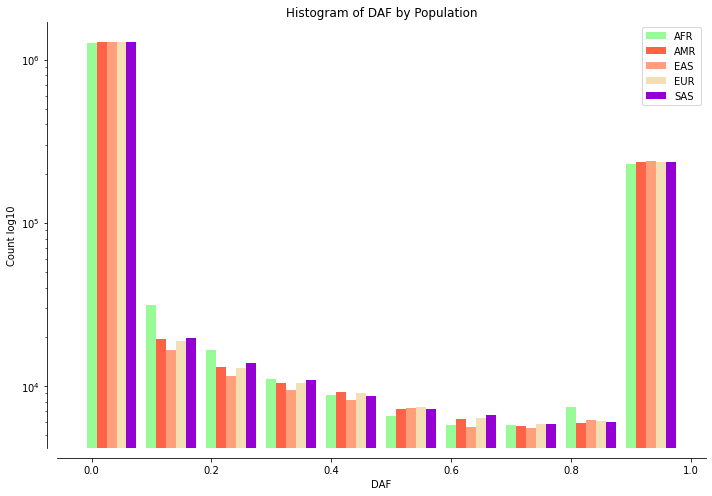

In [22]:
fig, ax = plt.subplots(figsize = (10,7))

afr_heights, afr_bins = np.histogram(AF_AA_df['DAF_AFR'][~np.isnan(AF_AA_df['DAF_AFR'])])
amr_heights, amr_bins = np.histogram(AF_AA_df['DAF_AMR'][~np.isnan(AF_AA_df['DAF_AMR'])], bins=afr_bins)
eas_heights, eas_bins = np.histogram(AF_AA_df['DAF_EAS'][~np.isnan(AF_AA_df['DAF_EAS'])], bins=afr_bins)
eur_heights, eur_bins = np.histogram(AF_AA_df['DAF_EUR'][~np.isnan(AF_AA_df['DAF_EUR'])], bins=afr_bins)
sas_heights, sas_bins = np.histogram(AF_AA_df['DAF_SAS'][~np.isnan(AF_AA_df['DAF_SAS'])], bins=afr_bins)

width = (afr_bins[1] - afr_bins[0])/6
plt.yscale('log')
ax.bar(afr_bins[:-1], afr_heights, width=width, facecolor='palegreen')
ax.bar(amr_bins[:-1]+width, amr_heights, width=width, facecolor='tomato')
ax.bar(eas_bins[:-1]+2*width, eas_heights, width=width, facecolor='lightsalmon')
ax.bar(eur_bins[:-1]+3*width, eur_heights, width=width, facecolor='wheat')
ax.bar(sas_bins[:-1]+4*width, sas_heights, width=width, facecolor='darkviolet')
ax.legend(['AFR', 'AMR', 'EAS', 'EUR', 'SAS'])
ax.set_title('Histogram of DAF by Population')
ax.set_ylabel('Count log10')
ax.set_xlabel('DAF')
sns.despine(ax=ax, offset=10)    
plt.tight_layout()
plt.show()

## Saving files to zarr

In [23]:
final_data = AF_AA_df.iloc[:, -5:]
df_to_zarr(df=final_data, path='../data/DAF.zarr')